In [1]:
import os
import numpy as np

import torch
torch.manual_seed(29)
from torch import nn
import torch.backends.cudnn as cudnn
import torch.nn.parallel
cudnn.benchmark = True
import torch.nn.functional as F

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from glob import glob
from PIL.PngImagePlugin import PngImageFile, PngInfo

from tqdm import tqdm

In [2]:
class quantclip(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    @staticmethod
    def forward(self, input, quant):
        """
        In the forward pass we receive a Tensor containing the input and return a
        Tensor containing the output. You can cache arbitrary Tensors for use in the
        backward pass using the save_for_backward method.
        """
        self.save_for_backward(input)
        c = (input.clamp(min=-1, max =1)+1)/2.0 * quant
        c = 2 * (c.round()/quant) - 1
        return c
    @staticmethod
    def backward(self, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = self.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < -1] = 0
        grad_input[input > 1] = 0
        return grad_input, None

class QuantCLIP(torch.nn.Module):

    def __init__(self, num_bits, dtype = torch.cuda.FloatTensor):
        super(QuantCLIP, self).__init__()

        self.quant = 2 ** num_bits - 1
        self.quantclip = quantclip

    def forward(self, input):
        return self.quantclip.apply(input, self.quant)

def getHAARFilters(num_filters):
    LL = np.asarray([[0.5, 0.5], [0.5, 0.5]])
    LH = np.asarray([[-0.5, -0.5], [0.5, 0.5]])
    HL = np.asarray([[-0.5, 0.5], [-0.5, 0.5]])
    HH = np.asarray([[0.5, -0.5], [-0.5, 0.5]])

    DWT = np.concatenate((LL[np.newaxis, ...],
                          LH[np.newaxis, ...],
                          HL[np.newaxis, ...],
                          HH[np.newaxis, ...]))[:, np.newaxis, ...]
    DWT = np.float32(DWT)
    DWT = torch.from_numpy(DWT)

    return DWT.repeat(num_filters, 1, 1, 1)

class HaarDWT(torch.nn.Module):
    def __init__(self, in_ch = 1):
        super(HaarDWT, self).__init__()

        weights = getHAARFilters(in_ch)

        self.conv = nn.Conv2d(in_ch, in_ch * 4, 2, stride=2, bias=False, groups = in_ch)
        self.conv.weight.data = weights
        self.conv.weight.requires_grad = False

    def forward(self, input):
        return self.conv(input)

class HaarIDWT(torch.nn.Module):
    def __init__(self, out_ch = 1):
        super(HaarIDWT, self).__init__()

        weights = getHAARFilters(out_ch)

        self.conv = nn.ConvTranspose2d(out_ch * 4, out_ch, 2, stride=2, bias=False, groups = out_ch)
        self.conv.weight.data = weights
        self.conv.weight.requires_grad = False

    def forward(self, input):
        return self.conv(input)


In [3]:
"""
Single CONV blocks:
"""
class BLOCK_3x3(nn.Module):
    def __init__(
        self, in_ch, out_ch, ker, stride = 1
        ):
        super(BLOCK_3x3, self).__init__()
        self.feat = nn.Sequential(
            nn.ReflectionPad2d(ker//2),
            nn.Conv2d(in_ch, out_ch, ker, stride = stride, bias = True)
            )

    def forward(self, x):
        x = self.feat(x)
        return x


"""
Residual CONV blocks:
"""
class RES_3x3_BLOCK1(nn.Module):
    """
        Residual Block:
            [INPUT] -> 2*[CONV 3x3] -> [OUTPUT] + [INPUT]
    """
    def __init__(
        self, in_ch, out_ch, ker, squeeze = 2, res_scale = 0.25
        ):
        super(RES_3x3_BLOCK1, self).__init__()

        self.skip = in_ch == out_ch
        self.rs = res_scale
        self.feat = nn.Sequential(
            nn.BatchNorm2d(in_ch),
            nn.ReLU(inplace=True),
            BLOCK_3x3(in_ch, out_ch//squeeze, ker),
            nn.BatchNorm2d(out_ch//squeeze),
            nn.ReLU(inplace=True),
            BLOCK_3x3(out_ch//squeeze, out_ch, ker),
            )

    def forward(self, x):
        out = self.feat(x)
        if self.skip: out = self.rs * out + x
        return out

"""
Enocder:
"""
class Encoder(nn.Module):
    def __init__(
        self,
        ):
        super(Encoder, self).__init__()

        self.E = nn.Sequential(
            HaarDWT(3),HaarDWT(12),
            BLOCK_3x3(in_ch = 48, out_ch = 96, ker = 3, stride = 1),
            RES_3x3_BLOCK1(in_ch = 96, out_ch = 96, ker = 3, squeeze = 2, res_scale = 1.0),
            RES_3x3_BLOCK1(in_ch = 96, out_ch = 96, ker = 3, squeeze = 2, res_scale = 1.0),
            nn.Conv2d(96, 3, 1),
            HaarDWT(3),HaarDWT(12),
            BLOCK_3x3(in_ch = 48, out_ch = 96, ker = 3, stride = 1),
            RES_3x3_BLOCK1(in_ch = 96, out_ch = 96, ker = 3, squeeze = 2, res_scale = 1.0),
            RES_3x3_BLOCK1(in_ch = 96, out_ch = 96, ker = 3, squeeze = 2, res_scale = 1.0),
            nn.Conv2d(96, 3, 1),
            QuantCLIP(8)
            )

    def forward(self, x):
        x = self.E(x)
        return x
"""
Deocder:
"""
class Decoder(nn.Module):
    def __init__(
        self,
        ):
        super(Decoder, self).__init__()

        self.D = nn.Sequential(
            BLOCK_3x3(in_ch = 3, out_ch = 192, ker = 3, stride = 1),
            RES_3x3_BLOCK1(in_ch = 192, out_ch = 192, ker = 3, squeeze = 4, res_scale = 1.0),
            RES_3x3_BLOCK1(in_ch = 192, out_ch = 192, ker = 3, squeeze = 4, res_scale = 1.0),
            nn.Conv2d(192, 48, 1),
            HaarIDWT(12),HaarIDWT(3),
            BLOCK_3x3(in_ch = 3, out_ch = 192, ker = 3, stride = 1),
            RES_3x3_BLOCK1(in_ch = 192, out_ch = 192, ker = 3, squeeze = 4, res_scale = 1.0),
            RES_3x3_BLOCK1(in_ch = 192, out_ch = 192, ker = 3, squeeze = 4, res_scale = 1.0),
            nn.Conv2d(192, 48, 1),
            HaarIDWT(12),HaarIDWT(3),
            nn.ReLU(),
            )

        self.S = nn.Sequential(nn.ReflectionPad2d(1),
                               nn.AvgPool2d(3, stride=1, padding=0))
        
    def forward(self, x):
        x = self.D(x)
        x = self.S(x)
        return x


In [6]:
de_model = Decoder()
check_point_file = "/home/cibitaw1/local/1WeStar/weights/submission_weights/decode.pth"
checkpoint = torch.load(check_point_file)
de_model.load_state_dict(checkpoint, strict = False)
de_model.cuda()
print('.')

en_model = Encoder()
check_point_file = "/home/cibitaw1/local/1WeStar/weights/submission_weights/encode.pth"
checkpoint = torch.load(check_point_file)
en_model.load_state_dict(checkpoint, strict = False)
en_model.cuda()
print('.')

.
.


In [5]:
de_model = Decoder()
check_point_file = "/media/cibitaw1/DATA/SP2020/compressACT/weights/"+\
"QuantACTShuffleV7_exp01/checkpoint.pth.tar"
checkpoint = torch.load(check_point_file)
de_model.load_state_dict(checkpoint['state_dict'], strict = False)
de_model.cuda()
print('.')

en_model = Encoder()
check_point_file = "/media/cibitaw1/DATA/SP2020/compressACT/weights/"+\
"QuantACTShuffleV7_exp01/checkpoint.pth.tar"
checkpoint = torch.load(check_point_file)
en_model.load_state_dict(checkpoint['state_dict'], strict = False)
en_model.cuda()
print('.')
torch.save(de_model.state_dict(), "/home/cibitaw1/local/1WeStar/weights/submission_weights/decode.pth")
torch.save(de_model.state_dict(), "/home/cibitaw1/local/1WeStar/submission_package/decode.pth")
torch.save(en_model.state_dict(), "/home/cibitaw1/local/1WeStar/weights/submission_weights/encode.pth")

.
.


In [7]:
def compress(I_org, model):

    e_ = 512
    c_ = 16
    d_ = e_ // c_
    pad_ = 4

    w, h = I_org.size

    comp_w_new = np.ceil(w/c_)
    comp_h_new = np.ceil(h/c_)

    new_w = int(e_ * np.ceil(w/e_))
    new_h = int(e_ * np.ceil(h/e_))

    com_w = new_w // c_
    com_h = new_h // c_

    I = np.uint8(I_org).copy()
    I = np.pad(I, ((0, int(new_h - h)),
                   (0, int(new_w - w)),
                   (0, 0)), mode = "reflect")
    I = Image.fromarray(I)


    I1 = np.float32(I)/255.0
    I1 = np.transpose(I1, [2, 0, 1])

    Enout = np.zeros((3, com_h, com_w))
    Enout_w = np.zeros((3, com_h, com_w))
    for i in list(np.arange(0, new_h, e_)):
        for j in list(np.arange(0, new_w, e_)):
            if i == 0:
                x1 = int(i)
                x2 = int((i + e_) + (pad_*2*c_))
            else:
                x1 = int(i - (pad_*c_))
                x2 = int((i + e_) + (pad_*c_))

            if j == 0:
                y1 = int(j)
                y2 = int((j + e_) + (pad_*2*c_))
            else:
                y1 = int(j - (pad_*c_))
                y2 = int((j + e_) + (pad_*c_))
            It = torch.from_numpy(np.expand_dims(I1[:, x1:x2, y1:y2], 0))
            Xe = model(It.cuda())
            Xe = (Xe + 1.0)/2.0
            Enout[:, x1//c_:x2//c_, y1//c_:y2//c_] += Xe.data.squeeze().cpu().numpy()
            Enout_w[:, x1//c_:x2//c_, y1//c_:y2//c_] += 1.0

    Enout = Enout/Enout_w
    Enout = np.uint8(255 * Enout.transpose([1, 2, 0]))

    Enout = Image.fromarray(Enout).crop((0, 0, comp_w_new, comp_h_new))

    return Enout


def compress2(I_org, model):
    
    c_ = 16
    
    w, h = I_org.size
    
    comp_w_new = np.ceil(w/c_)
    comp_h_new = np.ceil(h/c_)
    
    I = np.uint8(I_org).copy()
    I = np.pad(I, ((0, int(c_*np.ceil(I.shape[0]/c_) - I.shape[0])), 
                   (0, int(c_*np.ceil(I.shape[1]/c_) - I.shape[1])), 
                   (0, 0)), mode = "reflect")
    I = Image.fromarray(I)
    
    
    I1 = np.float32(I)/255.0
    I1 = np.transpose(I1, [2, 0, 1])
    I1 = torch.from_numpy(np.expand_dims(I1, 0))
    
    Xe = model(I1.cuda())
    Xe = (Xe + 1.0)/2.0
    Enout = Xe.data.squeeze().cpu().numpy()
    
    Enout = np.uint8(255 * Enout.transpose([1, 2, 0]))
    
    Enout = Image.fromarray(Enout).crop((0, 0, comp_w_new, comp_h_new))
    
    return Enout

In [8]:
def decompress(EnIn, model):

    e_ = 512
    c_ = 16
    d_ = e_ // c_
    pad_ = 4

    w, h = int(EnIn.text['w']), int(EnIn.text['h'])

    comp_w_new = np.ceil(w/c_)
    comp_h_new = np.ceil(h/c_)

    new_w = int(e_ * np.ceil(w/e_))
    new_h = int(e_ * np.ceil(h/e_))

    com_w = new_w // c_
    com_h = new_h // c_


    I = np.zeros((3,new_h,new_w), dtype = np.float32)
    I_w = np.zeros((3,new_h,new_w), dtype = np.float32)

    EnIn = np.uint8(EnIn).copy()
    EnIn = np.pad(EnIn, ((0, int(new_h - EnIn.shape[0])),
                         (0, int(new_w - EnIn.shape[1])),
                         (0, 0)), mode = "reflect")


    EnIn = np.float32(EnIn)/255.0
    EnIn = np.transpose(EnIn, [2, 0, 1])
    for i in list(np.arange(0, com_h, d_)):
        for j in list(np.arange(0, com_w, d_)):

            if i == 0:
                x1 = int(i)
                x2 = int((i + d_) + pad_*2)
            else:
                x1 = int(i - pad_)
                x2 = int((i + d_) + pad_)

            if j == 0:
                y1 = int(j)
                y2 = int((j + d_) + pad_*2)
            else:
                y1 = int(j - pad_)
                y2 = int((j + d_) + pad_)

            It = torch.from_numpy(np.expand_dims(EnIn[:, x1:x2, y1:y2], 0))
            It = It * 2.0 - 1.0
            Xe = model(It.cuda())
            I[:, x1*c_:x2*c_, y1*c_:y2*c_] += np.clip(Xe.data.squeeze().cpu().numpy(), 0, 1)
            I_w[:, x1*c_:x2*c_, y1*c_:y2*c_] += 1.0

    I = I/I_w

    I = np.uint8(255 * I.transpose([1, 2, 0]))
    I = Image.fromarray(I).crop((0, 0, w, h))

    return I

def decompress2(EnIn, model):
    
    c_ = 16
    
    w, h = int(EnIn.text['w']), int(EnIn.text['h'])
    
    
    I = np.zeros((3,int(c_*np.ceil(h/c_)),int(c_*np.ceil(w/c_))),
                 dtype = np.float32)
    
    new_en_w = I.shape[2]//c_
    new_en_h = I.shape[1]//c_
    
                 
    EnIn = np.uint8(EnIn).copy()
    EnIn = np.pad(EnIn, ((0, int(new_en_h - EnIn.shape[0])), 
                         (0, int(new_en_w - EnIn.shape[1])), 
                         (0, 0)), mode = "reflect")
    
    
    EnIn = np.float32(EnIn)/255.0
    EnIn = np.transpose(EnIn, [2, 0, 1])
    EnIn = torch.from_numpy(np.expand_dims(EnIn, 0))
    EnIn = EnIn * 2.0 - 1.0
    I = model(EnIn.cuda())
    I = np.clip(I.data.squeeze().cpu().numpy(), 0, 1)
    
    I = np.uint8(255 * I.transpose([1, 2, 0]))
    
    I = Image.fromarray(I).crop((0, 0, w, h))
    
    return I

In [11]:
img_file = "/media/cibitaw1/DATA/super_rez/professional_valid/valid/alberto-montalesi-176097.png"
I = Image.open(img_file).convert("RGB")

In [12]:
Enout = compress(I, en_model)

In [13]:
metadata = PngInfo()
metadata.add_text("w", str(I.size[0]))
metadata.add_text("h", str(I.size[1]))
Enout.save("test_en.png", pnginfo=metadata)
Enout = Image.open("test_en.png")

In [14]:
Iout = decompress2(Enout, de_model)

In [9]:
src_fldr = "/media/cibitaw1/DATA/super_rez/professional_valid/valid"
imgs = glob(src_fldr + os.sep + "*.png")
src_fldr = "/media/cibitaw1/DATA/super_rez/mobile_valid/valid"
imgs += glob(src_fldr + os.sep + "*.png")

In [10]:
dst_fldr = "/media/cibitaw1/DATA/super_rez/comp_test/compressed"

In [11]:
for img in tqdm(imgs):
    I = Image.open(img).convert("RGB")
    Enout = compress2(I, en_model)
    metadata = PngInfo()
    metadata.add_text("w", str(I.size[0]))
    metadata.add_text("h", str(I.size[1]))
    img_name = os.path.join(dst_fldr, img.split(os.sep)[-1])
    Enout.save(img_name, pnginfo=metadata)

100%|██████████| 102/102 [00:34<00:00,  7.65it/s]


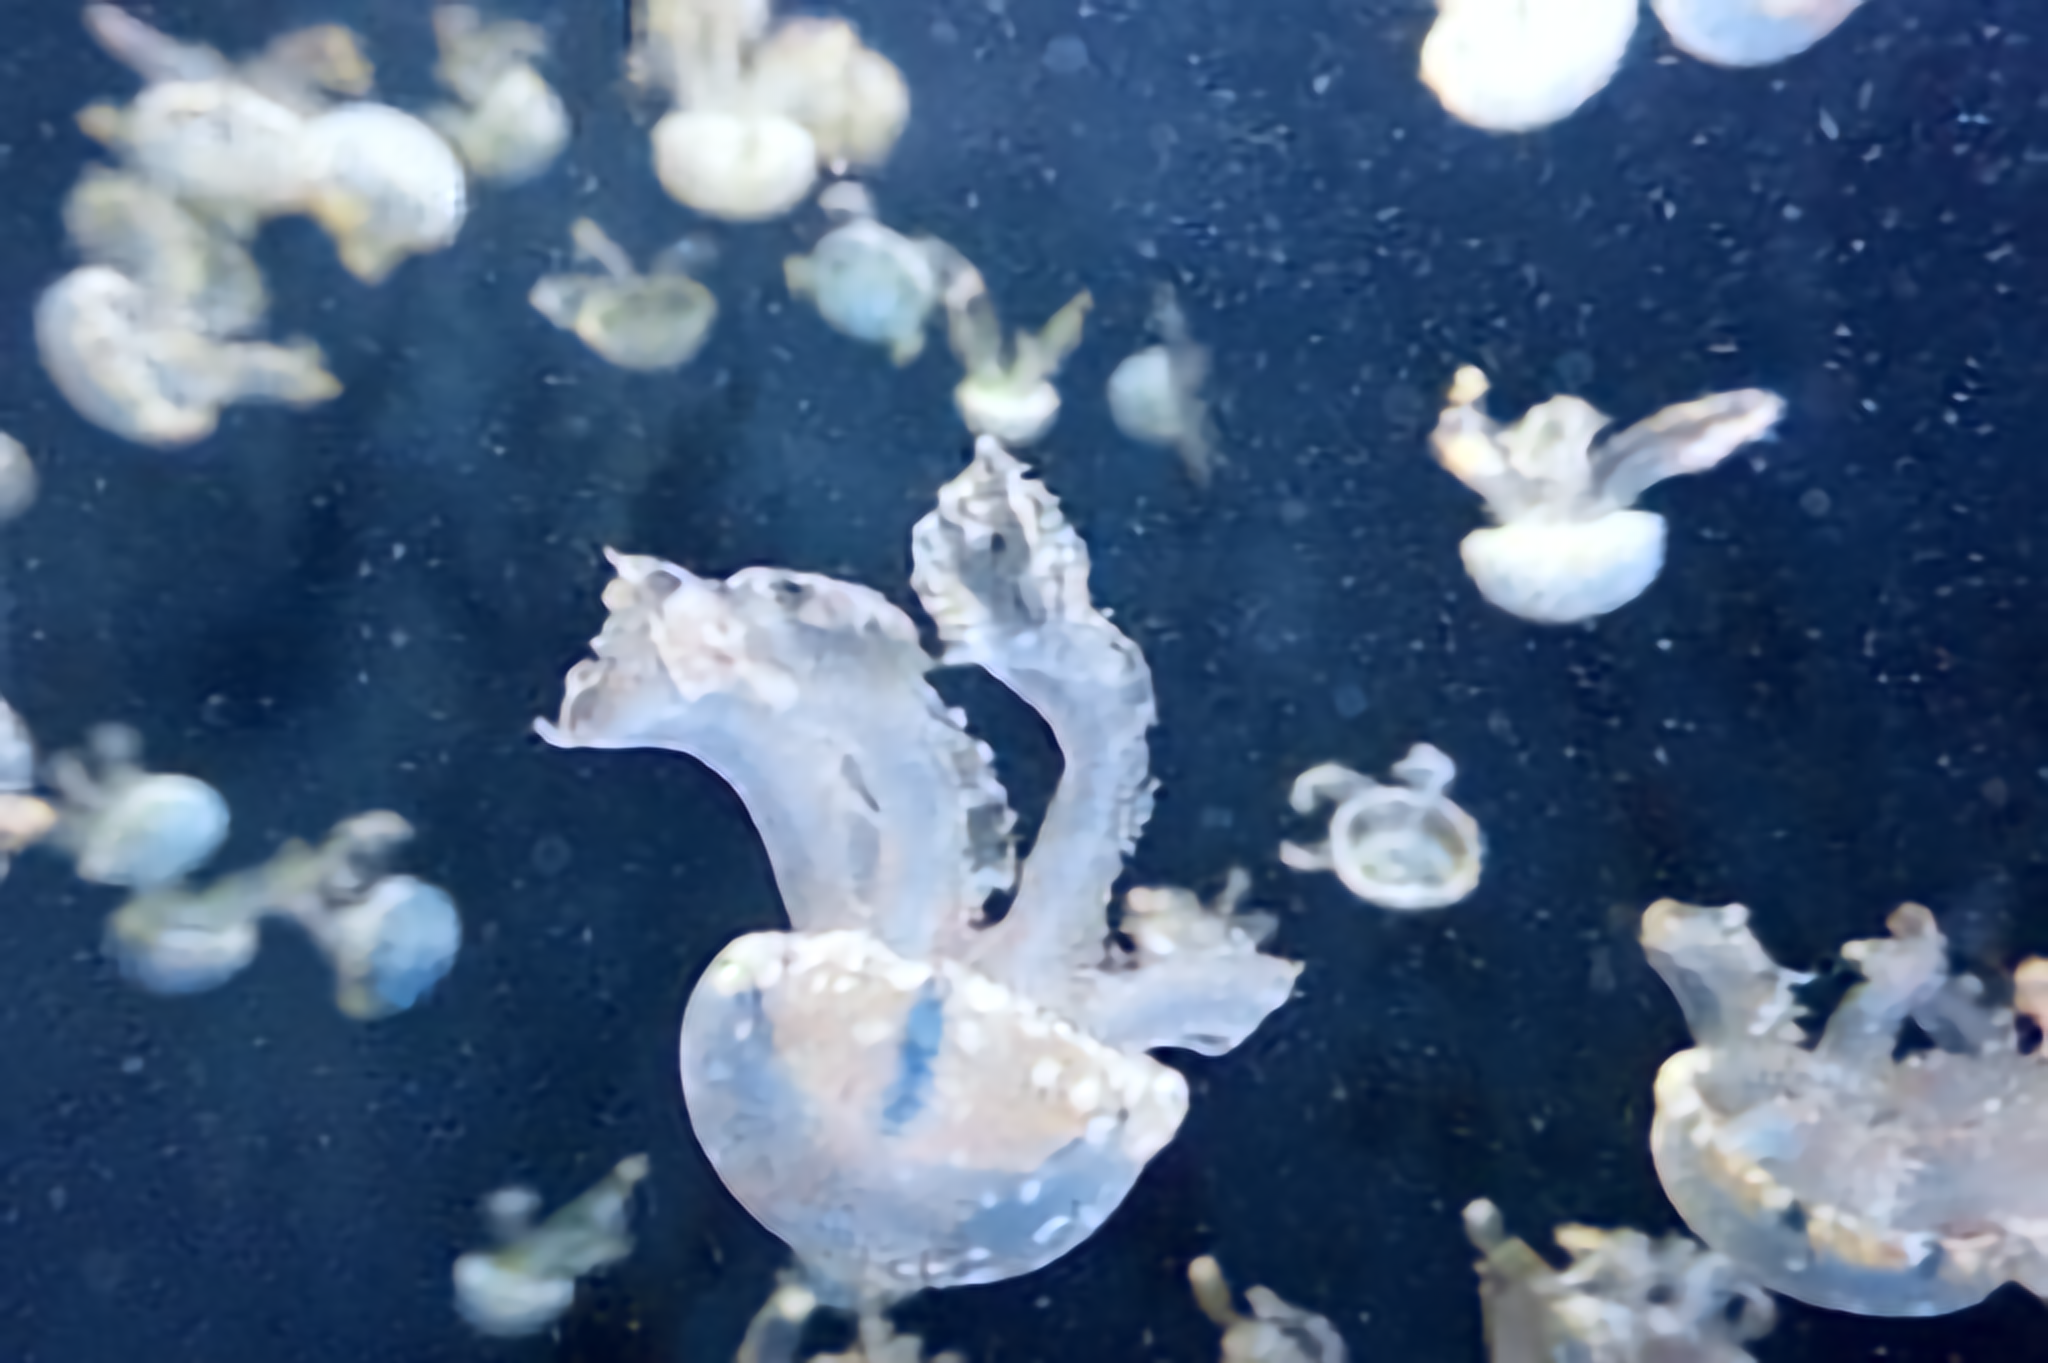

In [15]:
Iout